<a href="https://colab.research.google.com/github/rhondacodestuff/CIND-820-Capstone/blob/main/CIND820_InitialCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v1/fatal-police-shootings-data.csv", sep=',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8002 non-null   int64  
 1   name                     7548 non-null   object 
 2   date                     8002 non-null   object 
 3   manner_of_death          8002 non-null   object 
 4   armed                    7791 non-null   object 
 5   age                      7499 non-null   float64
 6   gender                   7971 non-null   object 
 7   race                     6485 non-null   object 
 8   city                     8002 non-null   object 
 9   state                    8002 non-null   object 
 10  signs_of_mental_illness  8002 non-null   bool   
 11  threat_level             8002 non-null   object 
 12  flee                     7036 non-null   object 
 13  body_camera              8002 non-null   bool   
 14  longitude               

In [5]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [6]:
df.duplicated().sum()

0

# Null Values

In [7]:
df.isna().sum()

id                            0
name                        454
date                          0
manner_of_death               0
armed                       211
age                         503
gender                       31
race                       1517
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        966
body_camera                   0
longitude                   840
latitude                    840
is_geocoding_exact            0
dtype: int64

<ipython-input-8-97cbc3757e57>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")


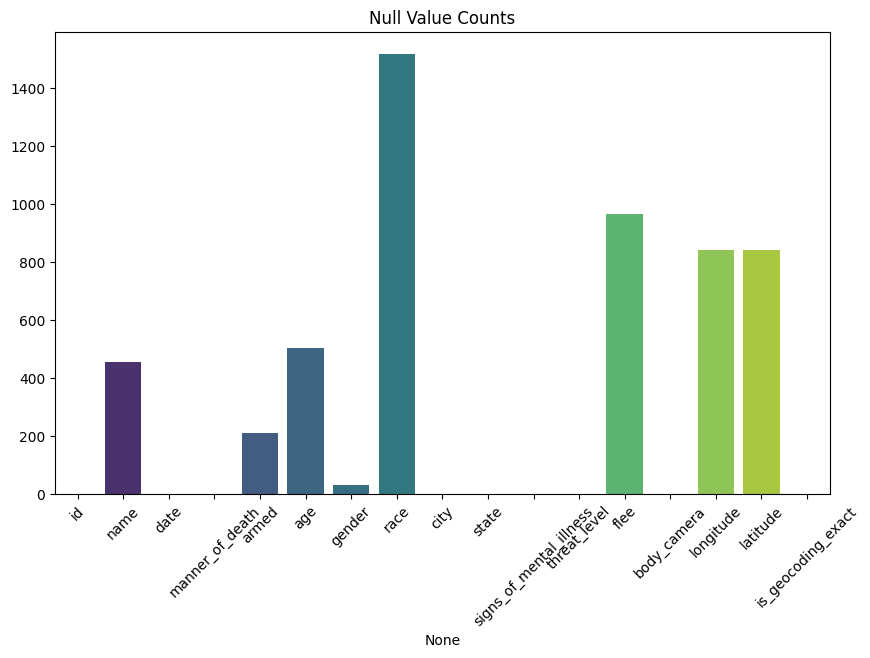

In [8]:
null_counts=df.isna().sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")
plt.title("Null Value Counts")
plt.xticks(rotation=45)
plt.show()

- **Id**: drop column
  - 100% unique values (high cardinality)
- **Name**: drop column
  - 99.5% unique values (high cardinality)
  - Anonymizes sensitive data
- **Longitude**: drop column
  - 87% unique values (high cardinality)
- **Latitude**: drop column
  - 76% unique values (high cardinality)
- **Is_geocoding_exact**: drop column
  - 'True' occurs 99.8% of time

In [9]:
df = df.drop(['id', 'name', 'latitude', 'longitude', 'is_geocoding_exact'], axis=1)

- **Armed**: drop rows with missing values (2.6%)
  - Reduce cardinality (106 distinct values) by classifying unique categories < 20 counts = 'Other'
  - This is done before splitting the dataset to maintain coherence of the classes


In [10]:
df = df.dropna(subset=['armed'])

In [11]:
df.armed.value_counts().head(20)

gun                4573
knife              1142
unarmed             460
undetermined        338
vehicle             284
toy weapon          248
unknown weapon      121
machete              65
Taser                39
ax                   30
sword                27
gun and knife        27
gun and vehicle      27
sharp object         25
hammer               22
baseball bat         20
BB gun               19
screwdriver          18
metal pipe           18
hatchet              16
Name: armed, dtype: int64

In [12]:
counts = df.armed.value_counts()
mask = df.armed.isin(counts[counts<20].index)
df['armed'][mask]='other'

In [13]:
df.armed.value_counts()

gun                4573
knife              1142
unarmed             460
other               343
undetermined        338
vehicle             284
toy weapon          248
unknown weapon      121
machete              65
Taser                39
ax                   30
sword                27
gun and knife        27
gun and vehicle      27
sharp object         25
hammer               22
baseball bat         20
Name: armed, dtype: int64

In [14]:
df['armed'].nunique()

17

- **Gender**: drop rows with missing values (0.4%)


In [15]:
df = df.dropna(subset=['gender'])

In [17]:
missing_values = pd.DataFrame(df.isnull().sum(), columns=['missing_count'])
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(df)) * 100

print(missing_values)

                         missing_count  missing_percentage
date                                 0            0.000000
manner_of_death                      0            0.000000
armed                                0            0.000000
age                                478            6.159794
gender                               0            0.000000
race                              1478           19.046392
city                                 0            0.000000
state                                0            0.000000
signs_of_mental_illness              0            0.000000
threat_level                         0            0.000000
flee                               938           12.087629
body_camera                          0            0.000000


# Data types
- *date*: convert to datetime object
- *signs_of_mental_illness*: convert to boolean
- *body_camera*: convert to boolean
- *manner_of_death*: convert to category
- *armed*: convert to category
- *gender*: convert to category
- *race*: convert to category
- *city*: convert to category
- *state*: convert to category
- *threat_level*: convert to category
- *flee*: convert to category

In [18]:
df['date']=pd.to_datetime(df['date'])

In [19]:
df['signs_of_mental_illness'] = df['signs_of_mental_illness'].astype(bool)
df['body_camera'] = df['body_camera'].astype(bool)

columns_to_convert_to_category = ['manner_of_death', 'armed', 'gender', 'race', 'city', 'state', 'threat_level', 'flee']
df[columns_to_convert_to_category] = df[columns_to_convert_to_category].astype('category')


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7760 entries, 0 to 8001
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     7760 non-null   datetime64[ns]
 1   manner_of_death          7760 non-null   category      
 2   armed                    7760 non-null   category      
 3   age                      7282 non-null   float64       
 4   gender                   7760 non-null   category      
 5   race                     6282 non-null   category      
 6   city                     7760 non-null   category      
 7   state                    7760 non-null   category      
 8   signs_of_mental_illness  7760 non-null   bool          
 9   threat_level             7760 non-null   category      
 10  flee                     6822 non-null   category      
 11  body_camera              7760 non-null   bool          
dtypes: bool(2), category(8), datetime6

For the remaining features with missing counts (age, race, and flee) these will be imputed after the train-test split to prevent data leakage.

# Train-Test split and Imputation

In [21]:
df2 = df.copy()

In [22]:
df2.drop(columns=['date', 'city', 'state'], inplace=True)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7760 entries, 0 to 8001
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   manner_of_death          7760 non-null   category
 1   armed                    7760 non-null   category
 2   age                      7282 non-null   float64 
 3   gender                   7760 non-null   category
 4   race                     6282 non-null   category
 5   signs_of_mental_illness  7760 non-null   bool    
 6   threat_level             7760 non-null   category
 7   flee                     6822 non-null   category
 8   body_camera              7760 non-null   bool    
dtypes: bool(2), category(6), float64(1)
memory usage: 183.3 KB


One-hot encode categorical variables (nominal)

In [24]:
df2_encoded = pd.get_dummies(data=df2, columns=['manner_of_death', 'armed', 'gender', 'race', 'threat_level', 'flee'])

df2_encoded

,age,signs_of_mental_illness,body_camera,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Taser,armed_ax,armed_baseball bat,armed_gun,armed_gun and knife,...,race_N,race_O,race_W,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,53.0,True,False,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,47.0,False,False,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
2,23.0,False,False,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,32.0,True,False,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
4,39.0,False,False,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7997,NaN,False,False,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7998,NaN,False,False,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7999,38.0,False,False,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
8000,NaN,False,False,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Train-test split

In [25]:
# Define the features and target variable
X = df2_encoded.drop(columns=['signs_of_mental_illness'])  # Replace 'target_column' with the name of your target column
y = df2_encoded['signs_of_mental_illness']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6208, 36) (6208,)
Testing set shape: (1552, 36) (1552,)


k-Nearest Neighbours imputation for one-hot encoded race and flee columns
- The observations with missing values are denoted by having 0s in all columns beginning with "race_" and "flee_"


In [27]:
# Identify the one-hot encoded columns for 'race' and 'flee'
race_columns = [col for col in X_train.columns if col.startswith('race_')]
flee_columns = [col for col in X_train.columns if col.startswith('flee_')]

# Find rows with all zero values across 'race' columns
missing_race_rows_train = X_train[(X_train[race_columns] == 0).all(axis=1)]
missing_race_rows_test = X_test[(X_test[race_columns] == 0).all(axis=1)]

# Find rows with all zero values across 'flee' columns
missing_flee_rows_train = X_train[(X_train[flee_columns] == 0).all(axis=1)]
missing_flee_rows_test = X_test[(X_test[flee_columns] == 0).all(axis=1)]

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values for 'race' in training and testing sets
X_train.loc[missing_race_rows_train.index, race_columns] = knn_imputer.fit_transform(X_train.loc[missing_race_rows_train.index, race_columns])
X_test.loc[missing_race_rows_test.index, race_columns] = knn_imputer.transform(X_test.loc[missing_race_rows_test.index, race_columns])

# Impute missing values for 'flee' in training and testing sets
X_train.loc[missing_flee_rows_train.index, flee_columns] = knn_imputer.fit_transform(X_train.loc[missing_flee_rows_train.index, flee_columns])
X_test.loc[missing_flee_rows_test.index, flee_columns] = knn_imputer.transform(X_test.loc[missing_flee_rows_test.index, flee_columns])

In [28]:
X_train.isnull().sum()

age                                 376
body_camera                           0
manner_of_death_shot                  0
manner_of_death_shot and Tasered      0
armed_Taser                           0
armed_ax                              0
armed_baseball bat                    0
armed_gun                             0
armed_gun and knife                   0
armed_gun and vehicle                 0
armed_hammer                          0
armed_knife                           0
armed_machete                         0
armed_other                           0
armed_sharp object                    0
armed_sword                           0
armed_toy weapon                      0
armed_unarmed                         0
armed_undetermined                    0
armed_unknown weapon                  0
armed_vehicle                         0
gender_F                              0
gender_M                              0
race_A                                0
race_B                                0


In [29]:
X_test.isnull().sum()

age                                 102
body_camera                           0
manner_of_death_shot                  0
manner_of_death_shot and Tasered      0
armed_Taser                           0
armed_ax                              0
armed_baseball bat                    0
armed_gun                             0
armed_gun and knife                   0
armed_gun and vehicle                 0
armed_hammer                          0
armed_knife                           0
armed_machete                         0
armed_other                           0
armed_sharp object                    0
armed_sword                           0
armed_toy weapon                      0
armed_unarmed                         0
armed_undetermined                    0
armed_unknown weapon                  0
armed_vehicle                         0
gender_F                              0
gender_M                              0
race_A                                0
race_B                                0


Impute age with median of training set

In [30]:
# Compute median of X_train's 'age' feature
age_median = X_train['age'].median()

# Impute median for missing values in X_train and X_test
X_train['age'].fillna(age_median, inplace=True)
X_test['age'].fillna(age_median, inplace=True)

# Training / Modeling (signs_of_mental_illness)
4 different models will be trained to predict signs_of_mental_illness
- Logistic Regression
- SVC (Support Vector Classification)
- Decision Tree
- Random Forest

In [31]:
# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

In [33]:
# Initialize models
logistic_regression = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

In [34]:
# Train models
logistic_regression.fit(X_train_scaled, y_train)
svc.fit(X_train_scaled, y_train)
decision_tree.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Predictions
lr_pred = logistic_regression.predict(X_test_scaled)
svc_pred = svc.predict(X_test_scaled)
dt_pred = decision_tree.predict(X_test_scaled)
rf_pred = random_forest.predict(X_test_scaled)

In [36]:
# Evaluate models
eval_table = PrettyTable()
eval_table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

models = ['Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest']
predictions = [lr_pred, svc_pred, dt_pred, rf_pred]

for i, preds in enumerate(predictions):
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)

    precision = report['True']['precision']
    recall = report['True']['recall']
    f1_score = report['True']['f1-score']

    eval_table.add_row([models[i], f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1_score:.4f}"])

print(eval_table)


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.7809  |   0.5000  | 0.0559 |  0.1005  |
|         SVC         |  0.7816  |   0.5714  | 0.0118 |  0.0231  |
|    Decision Tree    |  0.7120  |   0.2902  | 0.2176 |  0.2487  |
|    Random Forest    |  0.7223  |   0.3013  | 0.2029 |  0.2425  |
+---------------------+----------+-----------+--------+----------+


Confusion matrixes

In [55]:
models = ['Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest']
predictions = [lr_pred, svc_pred, dt_pred, rf_pred]

for model, preds in zip(models, predictions):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, preds)

    print(f"Confusion Matrix for {model}:")

    print(cm)

Confusion Matrix for Logistic Regression:
[[1193   19]
 [ 321   19]]
Confusion Matrix for SVC:
[[1209    3]
 [ 336    4]]
Confusion Matrix for Decision Tree:
[[1031  181]
 [ 266   74]]
Confusion Matrix for Random Forest:
[[1052  160]
 [ 271   69]]


# 10-Fold Cross Validation
- Check if the models are overfitting

In [37]:
# Perform cross-validation on Logistic Regression
acc_scores_train_logistic = cross_val_score(logistic_regression, X_train_scaled, y_train, scoring="accuracy", cv=10)
logistic_acc_mean = acc_scores_train_logistic.mean()

# Perform cross-validation on SVC
acc_scores_train_svc = cross_val_score(svc, X_train_scaled, y_train, scoring="accuracy", cv=10)
svc_acc_mean = acc_scores_train_svc.mean()

# Perform cross-validation on Decision Tree
acc_scores_train_tree = cross_val_score(decision_tree, X_train_scaled, y_train, scoring="accuracy", cv=10)
tree_acc_mean = acc_scores_train_tree.mean()

# Perform cross-validation on Random Forest
acc_scores_train_forest = cross_val_score(random_forest, X_train_scaled, y_train, scoring="accuracy", cv=10)
forest_acc_mean = acc_scores_train_forest.mean()

# Create a PrettyTable for evaluation
cv_table = PrettyTable()
cv_table.field_names = ["Model", "Cross-Validation Accuracy"]
cv_table.add_row(["Logistic Regression", logistic_acc_mean])
cv_table.add_row(["SVC", svc_acc_mean])
cv_table.add_row(["Decision Tree", tree_acc_mean])
cv_table.add_row(["Random Forest", forest_acc_mean])

print(cv_table)

+---------------------+---------------------------+
|        Model        | Cross-Validation Accuracy |
+---------------------+---------------------------+
| Logistic Regression |     0.7880175055841254    |
|         SVC         |     0.7891436808477481    |
|    Decision Tree    |     0.7300251934964417    |
|    Random Forest    |     0.7427512856474989    |
+---------------------+---------------------------+


All models produce only a slighly higher accuracy score compared to the original models, indicating that they generalize well to unseen data and are not overfitting. However, the gap between the original accuracy and cross-validation accuracy is slightly larger for the Decision Tree and Random Forest models. This could suggest that these tree-based models might have a bit more variance or tendency to overfit compared to the Logistic Regression and SVC models.

# Feature importance

Logistic Regression feature importance

In [47]:
# Get feature coefficients
coefficients = logistic_regression.coef_[0]

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': np.abs(coefficients)})

# Sort features by coefficient magnitude
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

feature_importance_df.head(10)

,Feature,Coefficient
34,flee_Not fleeing,0.323482
28,race_W,0.277332
20,armed_vehicle,0.225015
32,flee_Car,0.185607
11,armed_knife,0.165012
16,armed_toy weapon,0.128873
13,armed_other,0.109760
0,age,0.109282
1,body_camera,0.105684
19,armed_unknown weapon,0.104888


Decision Tree feature imoprtance

In [45]:
# Get feature importances for Decision Tree
dt_feature_importances = decision_tree.feature_importances_

# Create a DataFrame to store feature importance
dt_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': dt_feature_importances})

# Sort features by importance
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='Importance', ascending=False)

dt_feature_importance_df.head(10)


,Feature,Importance
0,age,0.424601
34,flee_Not fleeing,0.071654
1,body_camera,0.046449
30,threat_level_other,0.042741
24,race_B,0.036348
7,armed_gun,0.032334
25,race_H,0.030594
29,threat_level_attack,0.029473
28,race_W,0.029335
21,gender_F,0.021955


Random Forest feature importance

In [46]:
# Get feature importances for Random Forest
rf_feature_importances = random_forest.feature_importances_

# Create a DataFrame to store feature importance
rf_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_feature_importances})

# Sort features by importance
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

rf_feature_importance_df.head(10)


,Feature,Importance
0,age,0.576639
34,flee_Not fleeing,0.047876
1,body_camera,0.037951
28,race_W,0.034273
24,race_B,0.023334
25,race_H,0.020664
29,threat_level_attack,0.019871
11,armed_knife,0.019703
30,threat_level_other,0.019652
7,armed_gun,0.017804


I decided to use the top 10 features from Random Forest to re-train the models and compare their metrics because Random Forest is  an ensemble learning method built upon decision trees. Decision trees are known for their ability to capture complex non-linear relationships in data, making them suitable for a wide range of datasets. As a non-parametric method, decision trees do not make strong assumptions about the distribution of the data, allowing them to handle diverse data types effectively. Moreover, Random Forest aggregates multiple decision trees to reduce overfitting and improve generalization performance.

The feature importance in Random Forest is determined by assessing how much each feature contributes to reducing uncertainty in the target variable. This contribution is quantified by measuring the amount of reduction in Gini impurity, a metric that evaluates the homogeneity of a set of data points with respect to their class labels. Therefore, selecting the top features identified by Random Forest provides insights into the most influential factors driving the prediction task, potentially enhancing the interpretability and predictive performance of the models.

# Re-train models using top features from Random Forest

In [ ]:
# Create new training and testing datasets with selected features
selected_features = ['age', 'flee_Not fleeing', 'body_camera', 'race_W', 'race_B', 'race_H', 'threat_level_attack', 'armed_knife', 'threat_level_other', 'armed_gun']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain models using selected features
logistic_regression_selected = LogisticRegression(random_state=42)
svc_selected = SVC(random_state=42)
decision_tree_selected = DecisionTreeClassifier(random_state=42)
random_forest_selected = RandomForestClassifier(random_state=42)

logistic_regression_selected.fit(X_train_selected, y_train)
svc_selected.fit(X_train_selected, y_train)
decision_tree_selected.fit(X_train_selected, y_train)
random_forest_selected.fit(X_train_selected, y_train)

In [57]:
eval_table_selected = PrettyTable()
eval_table_selected.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Define the models and their predictions
models = [
    ("Logistic Regression", logistic_regression_selected),
    ("SVC", svc_selected),
    ("Decision Tree", decision_tree_selected),
    ("Random Forest", random_forest_selected)
]

for model_name, model in models:

    preds = model.predict(X_test_selected)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    precision = report['True']['precision']
    recall = report['True']['recall']
    f1 = report['True']['f1-score']

    eval_table_selected.add_row([model_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])

print(eval_table_selected)


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.7822  |   0.5833  | 0.0206 |  0.0398  |
|         SVC         |  0.7809  |   0.0000  | 0.0000 |  0.0000  |
|    Decision Tree    |  0.7455  |   0.3481  | 0.1853 |  0.2418  |
|    Random Forest    |  0.7429  |   0.3455  | 0.1941 |  0.2486  |
+---------------------+----------+-----------+--------+----------+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
